In [21]:
%run BI_df.py
%matplotlib inline

In [22]:
print(list(df))
print(len(list(df)))

['avg_talkTime_mins', 'branch_avg', 'branch_max', 'branch_min', 'calls_d/n', 'mpesa_avg', 'mpesa_limit', 'mpesa_max', 'mpesa_min', 'mshwari_avg', 'mshwari_max', 'mshwari_min', 'n_calls', 'n_contacts', 'n_devices', 'n_texts', 'texts_d/n', 'total_talkTime_hrs', 'transaction_success', 'status']
20


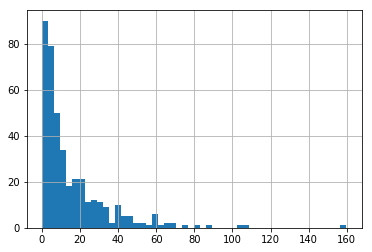

In [23]:
df['total_talkTime_hrs'].hist(bins=50)

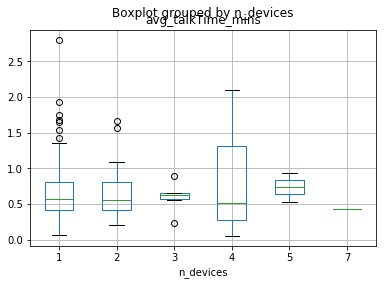

In [24]:
train.boxplot(column='avg_talkTime_mins', by='n_devices')
#perhaps n_texts by n_devices would be a better metric

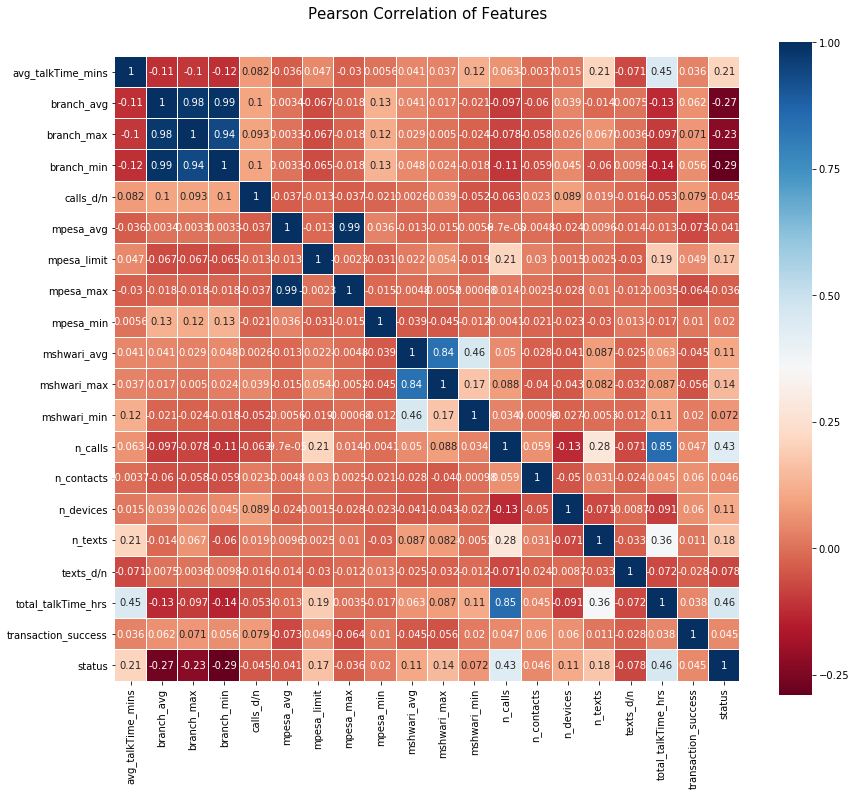

In [25]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [ ]:
pairs = sns.pairplot(df[['avg_talkTime_mins', 'calls_d/n', 'n_calls', 'n_contacts', 'n_devices', 'n_texts', 'texts_d/n', 'total_talkTime_hrs', 'transaction_success', 'status']], hue='status', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
pairs.set(xticklabels=[])

In [ ]:
from sklearn.preprocessing import LabelEncoder
fields = ['avg_talkTime_mins', 'calls_d/n', 'n_calls', 'n_contacts', 'n_devices', 'n_texts', 'texts_d/n', 'total_talkTime_hrs', 'transaction_success', 'status']
le = LabelEncoder()
for f in fields:
    df[f] = le.fit_transform(df[f])
#df.dtypes 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
def classification_model(model, data, predictors, target):
  #Fit the model:
  model.fit(data[predictors],data[target])
  
  #Make predictions on training set:
  predictions = model.predict(data[predictors])
  
  #Print accuracy
  accuracy = metrics.accuracy_score(predictions,data[target])
  print("Accuracy : %s" % "{0:.3%}".format(accuracy))

In [ ]:
target = 'status'
model = LogisticRegression()
predictors = ['talkTime(hrs)']
classification_model(model, train, predictors, test)